In [1]:
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import numpy as np
import gpytorch
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(1)

## PyTorch basics

In [3]:
a = torch.tensor([1,2,3])
print(a)

tensor([1, 2, 3])


In [4]:
b = np.array([2,3,4])
b = torch.from_numpy(b)
print(b)

tensor([2, 3, 4])


In [5]:
c = torch.add(a, b)
print(c)

tensor([3, 5, 7])


In [6]:
a_grad = torch.tensor([1.0,2.0,3.0], requires_grad=True)
print(a_grad)

tensor([1., 2., 3.], requires_grad=True)


In [7]:
c = a_grad**2
print(c)

tensor([1., 4., 9.], grad_fn=<PowBackward0>)


In [8]:
out = c.sum()
print(out)

tensor(14., grad_fn=<SumBackward0>)


In [9]:
out.backward()
print(a_grad.grad)

tensor([2., 4., 6.])


## Fit GP regression model

In [10]:
# define the objective function
def f(x, noise=0):
    return -torch.cos(np.pi*x) + torch.sin(4*np.pi*x) + noise*torch.randn(*x.shape)

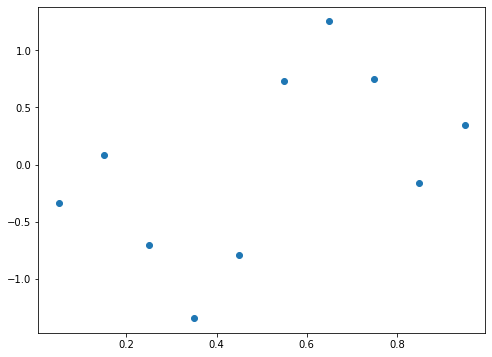

In [11]:
# observation noise
noise = 0.1
# number of observations
N = 10
# initial observations upon initiation
X_init = torch.linspace(0.05, 0.95, N)
y_init = f(X_init, noise=noise)
# plot noisy observations
plt.figure(figsize=(8, 6))
plt.plot(X_init.numpy(), y_init.numpy(), 'o');

In [12]:
# define mean and kernel functions
mean_fn = gpytorch.means.ConstantMean()
kernel_fn = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

In [13]:
# we will use the simplest form of GP model: exact inference
class GPRegressor(gpytorch.models.ExactGP):
    def __init__(self, X, y, mean, kernel, likelihood=None):
        # choose the standard observation model as required by exact GP inference
        if likelihood is None:
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
        # initiate the superclass ExactGP to refresh the posterior
        super().__init__(X, y, likelihood)
        # store attributes
        self.mean = mean
        self.kernel = kernel
        self.likelihood = likelihood
    
    # compute the posterior distribution after conditioning on the training data
    def forward(self, x):
        mean_x = self.mean(x)
        covar_x = self.kernel(x)
        # return a posterior multivariate normal distribution
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    # compute the marginal predictive distribution of y given x
    def predict(self, x):
        # set to evaluation mode
        self.eval()
        # perform inference without gradient propagation
        with torch.no_grad():
            # get posterior distribution p(f|x)
            pred = self(x)
            # convert posterior distribution p(f|x) to p(y|x)
            return self.likelihood(pred)

In [14]:
model = GPRegressor(X_init, y_init, mean_fn, kernel_fn)

In [15]:
def plot_model(model, xlim=None):
    """
    Plot 1D GP model
    we
    input:
    model : gpytorch.models.GP
    xlim : the limit of x axis, tuple(float, float) or None
    """
    # extract training data in numpy format
    X_train = model.train_inputs[0].cpu().numpy()
    y_train = model.train_targets.cpu().numpy()
    # obtain range of x axis
    if xlim is None:
        xmin = float(X_train.min())
        xmax = float(X_train.max())
        x_range = xmax - xmin
        xlim = [xmin - 0.05 * x_range,
                xmax + 0.05 * x_range]
    # create a list of equally spaced input locations
    X_plot = torch.linspace(xlim[0], xlim[1], 200)
    # generate predictive posterior distribution
    model.eval()
    predictive_distribution = model.predict(X_plot)
    # obtain mean, upper and lower bounds
    lower, upper = predictive_distribution.confidence_region()
    prediction = predictive_distribution.mean.cpu().numpy()
    X_plot = X_plot.numpy()

    plt.scatter(X_train, y_train, marker='x', c='k')
    plt.plot(X_plot, prediction)
    plt.fill_between(X_plot, lower, upper, alpha=0.1)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)

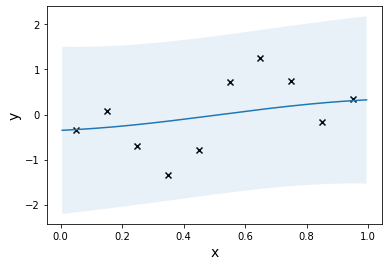

In [16]:
plot_model(model)

## Fine-tuning the length-scale of the kernel function

In [17]:
def plot_kernel(kernel, xlim=None, ax=None):
    if xlim is None:
        xlim = [-3, 3]
    x = torch.linspace(xlim[0], xlim[1], 100)
    # call the evaluate() function to perform the actual evaluation
    with torch.no_grad():
        K = kernel(x, torch.zeros((1))).evaluate().reshape(-1, 1)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.plot(x.numpy(), K.cpu().numpy())

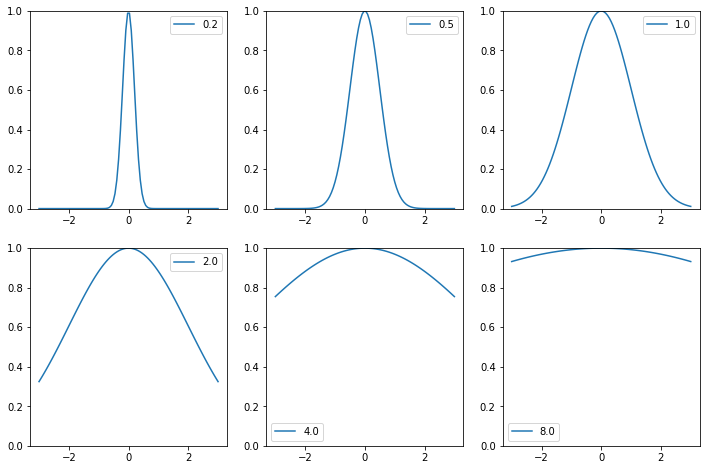

In [18]:
k = gpytorch.kernels.RBFKernel()
all_lengthscale = np.asarray([0.2, 0.5, 1, 2, 4, 8])
figure, axes = plt.subplots(2, 3, figsize=(12, 8))
for tmp_lengthscale, ax in zip(all_lengthscale, axes.ravel()):
    k.lengthscale = tmp_lengthscale
    plot_kernel(k, ax=ax)
    ax.set_ylim([0, 1])
    ax.legend([tmp_lengthscale])

In [19]:
kernel_fn.base_kernel.lengthscale

tensor([[0.6931]], grad_fn=<SoftplusBackward0>)

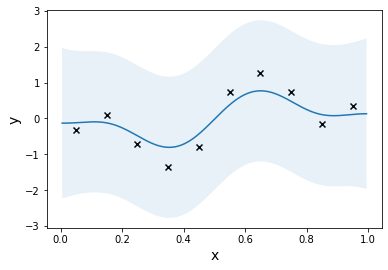

In [20]:
# manually fine tune lengthscale
kernel_fn.base_kernel.lengthscale = 0.1
model = GPRegressor(X_init, y_init, mean_fn, kernel_fn)
plot_model(model)

In [21]:
# fine tune hyperparameters (lengthscale and noise variance) by optimizing MLE
def train(model, X, y, n_epochs=100, lr=0.3, verbose=True):
    # switch to model training mode
    model.train()
    # Use the adam optimizer
    training_parameters = model.parameters()
    optimizer = torch.optim.Adamax(training_parameters, lr=lr)
    # initiate a GP model with Gaussian likelihood for MLL calculation
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    # start the training loop
    for e in range(n_epochs):
        # clear gradients to prevent gradient accumulation
        optimizer.zero_grad()
        # get posterior distribution p(f|x)
        out = model(X)
        # get negated exact marginal log likelihood p(y|x)
        loss = -mll(out, y)
        # caculated gradients using autograd
        loss.backward()
        # perform gradient update
        optimizer.step()
        # print optimization log
        if verbose:
            if e % 5 == 0:
                lengthscale = model.kernel.base_kernel.lengthscale.squeeze(0).detach().cpu().numpy()
                print(f"Epoch: {e}, loss: {loss.item():.3f}, lengthscale: {lengthscale[0]:.3f}, noise: {model.likelihood.noise.item():.3f}")
                # print(f"Loss: {loss.item():.3f}, lengthscale: {lengthscale}")   

In [22]:
train(model, X_init, y_init)

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Epoch: 0, loss: 1.214, lengthscale: 0.133, noise: 0.554
Epoch: 5, loss: 1.001, lengthscale: 0.113, noise: 0.190
Epoch: 10, loss: 0.921, lengthscale: 0.110, noise: 0.083
Epoch: 15, loss: 0.854, lengthscale: 0.124, noise: 0.042
Epoch: 20, loss: 0.834, lengthscale: 0.139, noise: 0.024
Epoch: 25, loss: 0.832, lengthscale: 0.131, noise: 0.017
Epoch: 30, loss: 0.831, lengthscale: 0.129, noise: 0.014
Epoch: 35, loss: 0.831, lengthscale: 0.127, noise: 0.013
Epoch: 40, loss: 0.830, lengthscale: 0.121, noise: 0.013
Epoch: 45, loss: 0.830, lengthscale: 0.124, noise: 0.014
Epoch: 50, loss: 0.829, lengthscale: 0.124, noise: 0.016
Epoch: 55, loss: 0.828, lengthscale: 0.127, noise: 0.017
Epoch: 60, loss: 0.827, lengthscale: 0.129, noise: 0.018
Epoch: 65, loss: 0.827, lengthscale: 0.129, noise: 0.019
Epoch: 70, loss: 0.827, lengthscale: 0.129, noise: 0.019
Epoch: 75, loss: 0.827, lengthscale: 0.128, noise: 0.019
Epoch: 80, loss: 0.827, lengthscale: 0.127, noise: 0.019
Epoch: 85, loss: 0.827, lengthsca

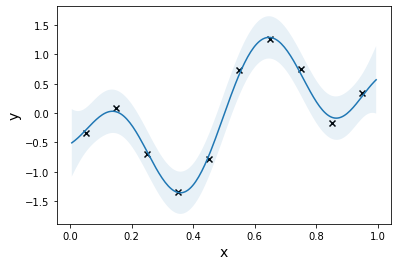

In [23]:
plot_model(model)

In [24]:
kernel_fn.base_kernel.lengthscale

tensor([[0.1279]], grad_fn=<SoftplusBackward0>)

## Fine tune noise variance

In [25]:
model.likelihood.noise

tensor([0.0183], grad_fn=<AddBackward0>)

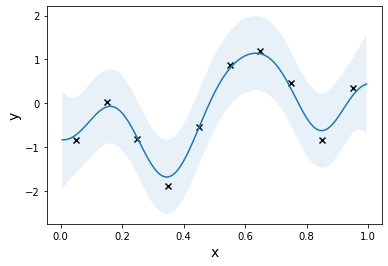

In [31]:
model.likelihood.noise = 0.1
plot_model(model)

Epoch: 0, loss: 1.331, lengthscale: 0.096, noise: 0.554
Epoch: 5, loss: 1.242, lengthscale: 0.084, noise: 0.244
Epoch: 10, loss: 1.211, lengthscale: 0.093, noise: 0.175
Epoch: 15, loss: 1.204, lengthscale: 0.098, noise: 0.124
Epoch: 20, loss: 1.194, lengthscale: 0.095, noise: 0.086
Epoch: 25, loss: 1.187, lengthscale: 0.091, noise: 0.062
Epoch: 30, loss: 1.185, lengthscale: 0.091, noise: 0.047
Epoch: 35, loss: 1.182, lengthscale: 0.093, noise: 0.039
Epoch: 40, loss: 1.181, lengthscale: 0.095, noise: 0.032
Epoch: 45, loss: 1.180, lengthscale: 0.095, noise: 0.028
Epoch: 50, loss: 1.179, lengthscale: 0.094, noise: 0.024
Epoch: 55, loss: 1.178, lengthscale: 0.093, noise: 0.022
Epoch: 60, loss: 1.177, lengthscale: 0.094, noise: 0.020
Epoch: 65, loss: 1.177, lengthscale: 0.094, noise: 0.018
Epoch: 70, loss: 1.177, lengthscale: 0.094, noise: 0.017
Epoch: 75, loss: 1.176, lengthscale: 0.094, noise: 0.015
Epoch: 80, loss: 1.176, lengthscale: 0.094, noise: 0.014
Epoch: 85, loss: 1.176, lengthsca

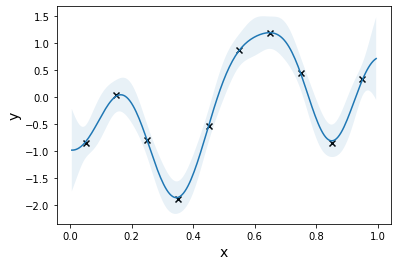

In [27]:
y_init = f(X_init, noise=0.5)
model = GPRegressor(X_init, y_init, mean_fn, kernel_fn)
train(model, X_init, y_init)
plot_model(model)

In [28]:
model.likelihood.noise

tensor([0.0114], grad_fn=<AddBackward0>)

In [29]:
# fine tune hyperparameters (lengthscale and noise variance) by optimizing MLE
def train(model, X, y, n_epochs=100, lr=0.3, verbose=True, fixed_noise_variance=None):
    # switch to model training mode
    model.train()
    if fixed_noise_variance is not None:
        model.likelihood.noise = fixed_noise_variance
        training_parameters = [p for name, p in model.named_parameters() if not name.startswith('likelihood')]
    else:
        training_parameters = model.parameters()
    optimizer = torch.optim.Adamax(training_parameters, lr=lr)
    # initiate a GP model with Gaussian likelihood for MLL calculation
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    # start the training loop
    for e in range(n_epochs):
        # clear gradients to prevent gradient accumulation
        optimizer.zero_grad()
        # get posterior distribution p(f|x)
        out = model(X)
        # get negated exact marginal log likelihood p(y|x)
        loss = -mll(out, y)
        # caculated gradients using autograd
        loss.backward()
        # perform gradient update
        optimizer.step()
        # print optimization log
        if verbose:
            if e % 5 == 0:
                lengthscale = model.kernel.base_kernel.lengthscale.squeeze(0).detach().cpu().numpy()
                print(f"Epoch: {e}, loss: {loss.item():.3f}, lengthscale: {lengthscale[0]:.3f}, noise: {model.likelihood.noise.item():.3f}")
                # print(f"Loss: {loss.item():.3f}, lengthscale: {lengthscale}")   

Epoch: 0, loss: 1.199, lengthscale: 0.125, noise: 0.100
Epoch: 5, loss: 1.219, lengthscale: 0.081, noise: 0.100
Epoch: 10, loss: 1.198, lengthscale: 0.090, noise: 0.100
Epoch: 15, loss: 1.201, lengthscale: 0.096, noise: 0.100
Epoch: 20, loss: 1.195, lengthscale: 0.092, noise: 0.100
Epoch: 25, loss: 1.196, lengthscale: 0.092, noise: 0.100
Epoch: 30, loss: 1.194, lengthscale: 0.096, noise: 0.100
Epoch: 35, loss: 1.195, lengthscale: 0.096, noise: 0.100
Epoch: 40, loss: 1.194, lengthscale: 0.093, noise: 0.100
Epoch: 45, loss: 1.194, lengthscale: 0.092, noise: 0.100
Epoch: 50, loss: 1.194, lengthscale: 0.093, noise: 0.100
Epoch: 55, loss: 1.194, lengthscale: 0.094, noise: 0.100
Epoch: 60, loss: 1.194, lengthscale: 0.093, noise: 0.100
Epoch: 65, loss: 1.194, lengthscale: 0.094, noise: 0.100
Epoch: 70, loss: 1.194, lengthscale: 0.094, noise: 0.100
Epoch: 75, loss: 1.194, lengthscale: 0.094, noise: 0.100
Epoch: 80, loss: 1.194, lengthscale: 0.094, noise: 0.100
Epoch: 85, loss: 1.194, lengthsca

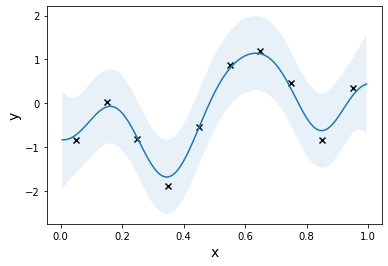

In [30]:
model = GPRegressor(X_init, y_init, mean_fn, kernel_fn)
train(model, X_init, y_init, fixed_noise_variance=0.1)
plot_model(model)